# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Network_Traffic_data.csv")
y_raw = data['Length'].values

# Plot raw data

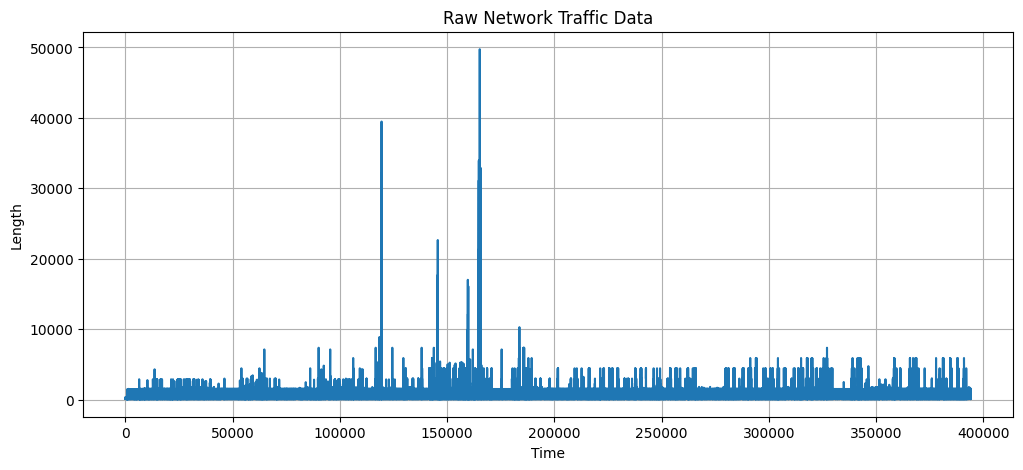

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(y_raw)
plt.title("Raw Network Traffic Data")
plt.xlabel("Time")
plt.ylabel("Length")
plt.grid(True)
plt.show()

# Check for stationarity

In [6]:
pip install statsmodels

# KPSS test

In [7]:
from statsmodels.tsa.stattools import kpss

In [9]:
from statsmodels.tsa.stattools import kpss

# Standardize
y_std = (y_raw - np.mean(y_raw)) / np.std(y_raw)

# KPSS Stationarity Check
def check_stationarity_kpss(series, name="Series"):
    statistic, p_value, _, _ = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Statistic for {name}: {statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print("=> Stationary ✅" if p_value > 0.05 else "=> NOT Stationary ❌")
    return p_value > 0.05  # True if stationary

check_stationarity_kpss(y_std, "Standardized Data")

KPSS Statistic for Standardized Data: 16.4936
p-value: 0.0100
=> NOT Stationary ❌


/tmp/ipython-input-9-2503153365.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(series, regression='c', nlags='auto')


np.False_

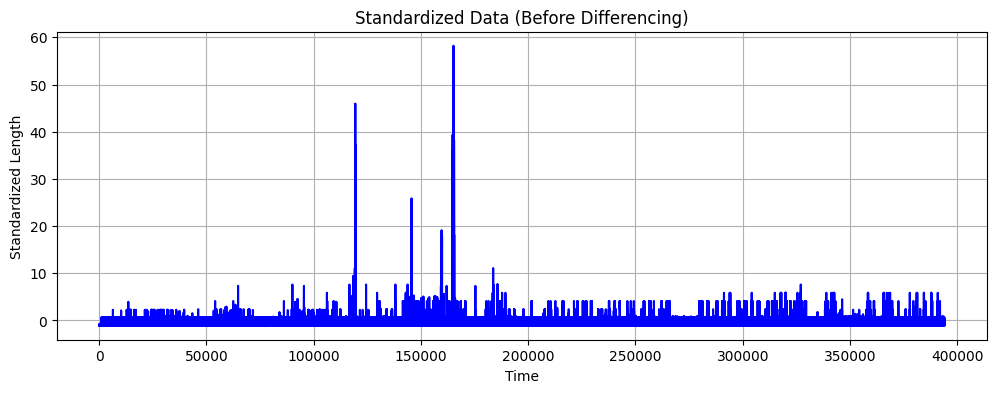

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(y_std, color='blue')
plt.title("Standardized Data (Before Differencing)")
plt.xlabel("Time")
plt.ylabel("Standardized Length")
plt.grid(True)
plt.show()

# Differencing + KPSS re-test

In [11]:
# Make stationary using differencing
y_diff = np.diff(y_std)

# Re-test with KPSS
check_stationarity_kpss(y_diff, "Differenced Data")

KPSS Statistic for Differenced Data: 0.0018
p-value: 0.1000
=> Stationary ✅


/tmp/ipython-input-9-2503153365.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, _ = kpss(series, regression='c', nlags='auto')


np.True_

#Plot differenced data

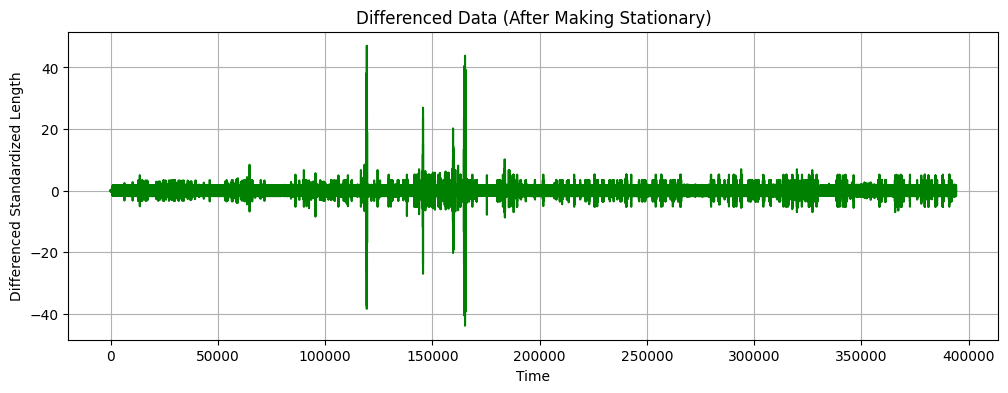

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(y_diff, color='green')
plt.title("Differenced Data (After Making Stationary)")
plt.xlabel("Time")
plt.ylabel("Differenced Standardized Length")
plt.grid(True)
plt.show()

# Train/Test Split

In [13]:
train_size = int(0.8 * len(y_diff))
train, test = y_diff[:train_size], y_diff[train_size:]

# Estimation of alpha

In [14]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00


In [15]:
import numpy as np
from scipy.stats import norm
data = df['Length'].dropna().values

def regression_type_alpha_estimator(data):
    N = len(data)
    sorted_data = np.sort(np.abs(data))
    p = np.linspace(1/(N+1), N/(N+1), N)
    q = norm.ppf((1 + p) / 2)  # quantiles
    log_q = np.log(q)
    log_data = np.log(sorted_data)

    # Linear regression: log|X| ~ log(q)
    coeffs = np.polyfit(log_q, log_data, 1)
    slope = coeffs[0]

    # α is approximately 1/slope
    alpha_est = 1 / slope
    return round(alpha_est, 3)

alpha = regression_type_alpha_estimator(data)
print("Estimated α (regression-type):", alpha)

Estimated α (regression-type): 0.889


# Estimation of A & B floc parameters

In [18]:
alpha = 0.889
A = round((alpha - 0.1) / 2 + 0.1, 3)  # Using FLOC estimation method
B = round((alpha - 0.1) / 2 - 0.1, 3)
print(f"Using A = {A}, B = {B} for FLOC (A + B = {A + B})")


Using A = 0.495, B = 0.294 for FLOC (A + B = 0.7889999999999999)


In [19]:
def floc(X, lag, A, B):
    X = np.asarray(X)
    N = len(X)
    if lag == 0:
        return np.mean(np.abs(X)**(A + B))
    else:
        return np.mean((np.abs(X[lag:])**A) * (np.abs(X[:-lag])**B) * np.sign(X[lag:] * X[:-lag]))


In [20]:
def estimate_ar_floc(X, p, A, B):
    K = np.zeros((p, p))
    k_vec = np.zeros(p)

    for i in range(p):
        k_vec[i] = floc(X, i+1, A, B)
        for j in range(p):
            K[i, j] = floc(X, abs(i - j), A, B)

    phi_hat = np.linalg.solve(K, k_vec)
    return phi_hat


In [22]:
p = 2
phi_floc = estimate_ar_floc(y_diff, p, A, B)
print(f"Estimated AR({p}) coefficients using FLOC: {phi_floc}")


Estimated AR(2) coefficients using FLOC: [-0.8822071  -0.45813367]


In [23]:
def compute_residuals(X, phi):
    p = len(phi)
    N = len(X)
    residuals = []
    for t in range(p, N):
        pred = sum(phi[j] * X[t - j - 1] for j in range(p))
        residuals.append(X[t] - pred)
    return np.array(residuals)

residuals = compute_residuals(y_diff, phi_floc)
print("Mean Residual:", np.mean(residuals))
print("Std Dev of Residual:", np.std(residuals))


Mean Residual: 1.0619118936646272e-07
Std Dev of Residual: 0.9631169584268062


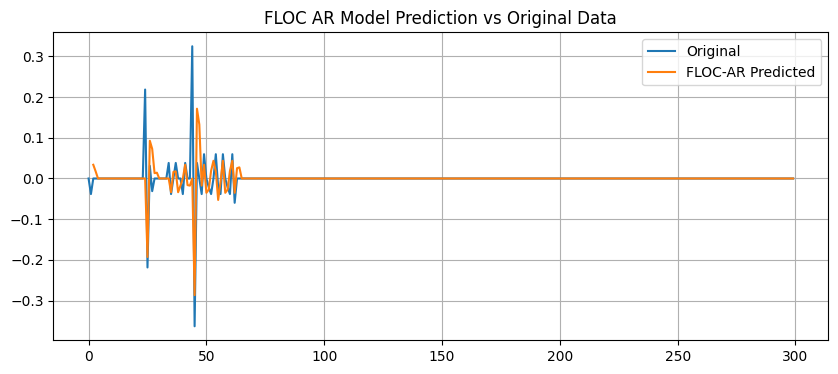

In [24]:
import matplotlib.pyplot as plt

predicted = [sum(phi_floc[j] * y_diff[t - j - 1] for j in range(len(phi_floc)))
             for t in range(len(phi_floc), len(y_diff))]

plt.figure(figsize=(10, 4))
plt.plot(y_diff[:300], label="Original")
plt.plot(range(len(phi_floc), 300), predicted[:300 - len(phi_floc)], label="FLOC-AR Predicted")
plt.title("FLOC AR Model Prediction vs Original Data")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import pandas as pd

# Create time index — same length as y_diff
ts_stationary = pd.Series(y_diff, name="StationaryDiff")

In [27]:
def forecast_ar_floc_aligned(ts_series, phi):

    X = ts_series.values
    index = ts_series.index
    p = len(phi)

    # Start with NaN padding for first p points
    fitted = [np.nan] * p

    # Compute fitted values
    for t in range(p, len(X)):
        pred = sum(phi[i] * X[t - i - 1] for i in range(p))
        fitted.append(pred)

    return pd.Series(fitted, index=index)

In [28]:
phi = estimate_ar_floc(ts_stationary, p=2, A=A, B=B)
fitted_values = forecast_ar_floc_aligned(ts_stationary, phi)


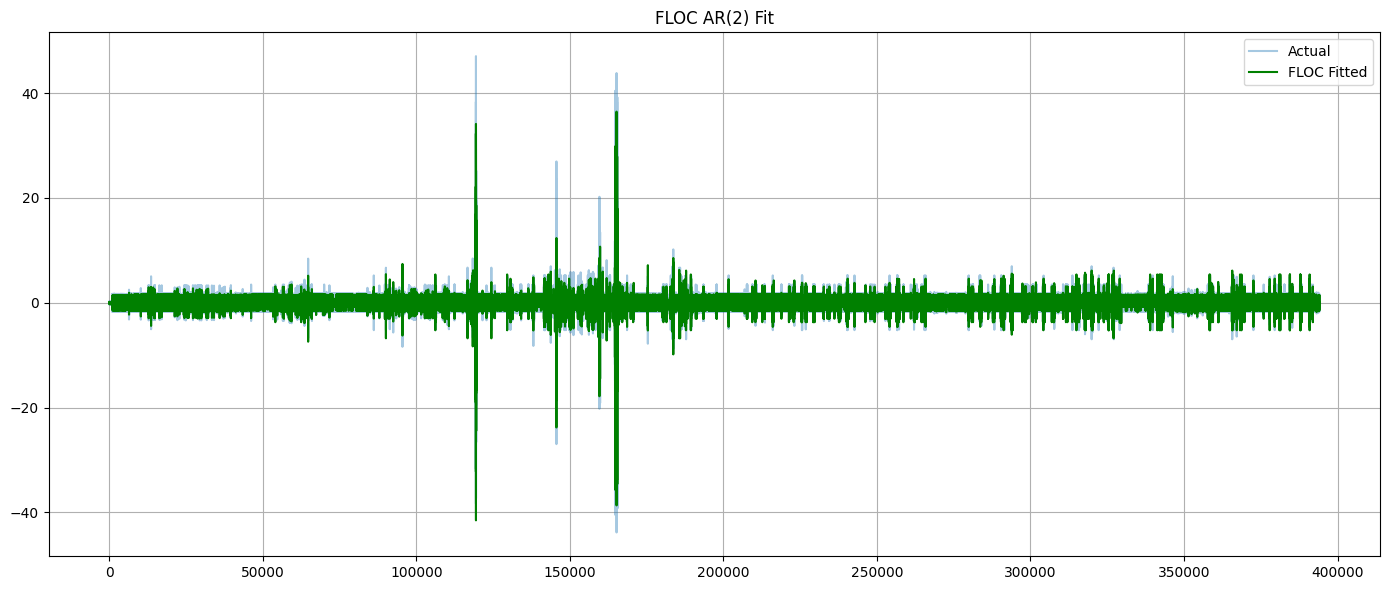

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(ts_stationary.index, ts_stationary, label='Actual', alpha=0.4)
plt.plot(fitted_values.index, fitted_values, label='FLOC Fitted', color='green')
plt.title("FLOC AR(2) Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



🔷 Fitting FLOC AR(2) model
Estimated coefficients: [-0.88219377 -0.45812475]


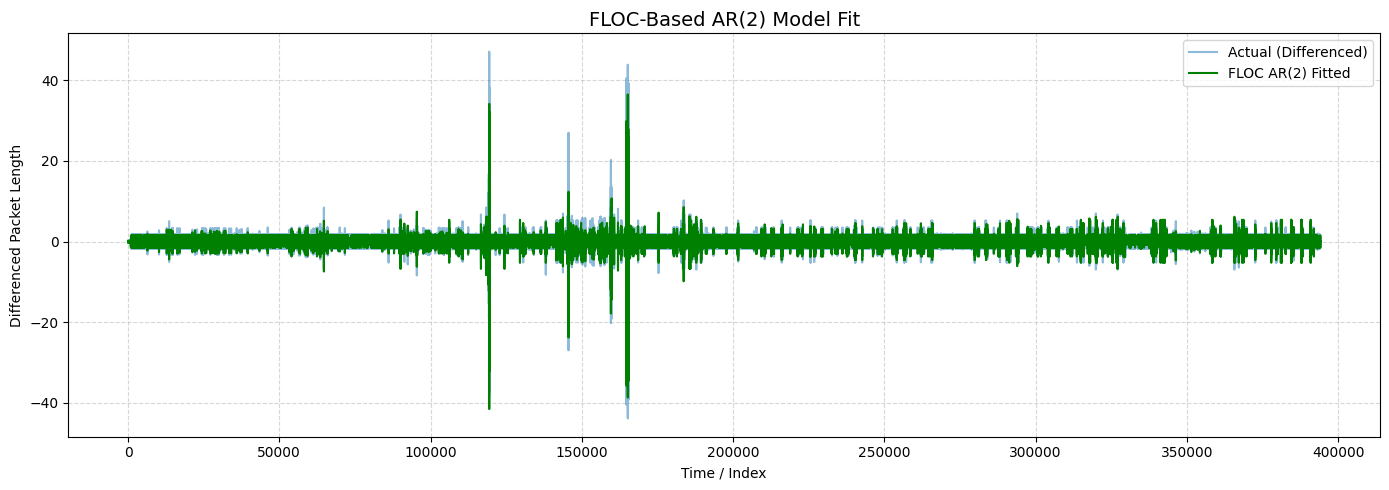


🔷 Fitting FLOC AR(3) model
Estimated coefficients: [-0.98062366 -0.64766753 -0.21485391]


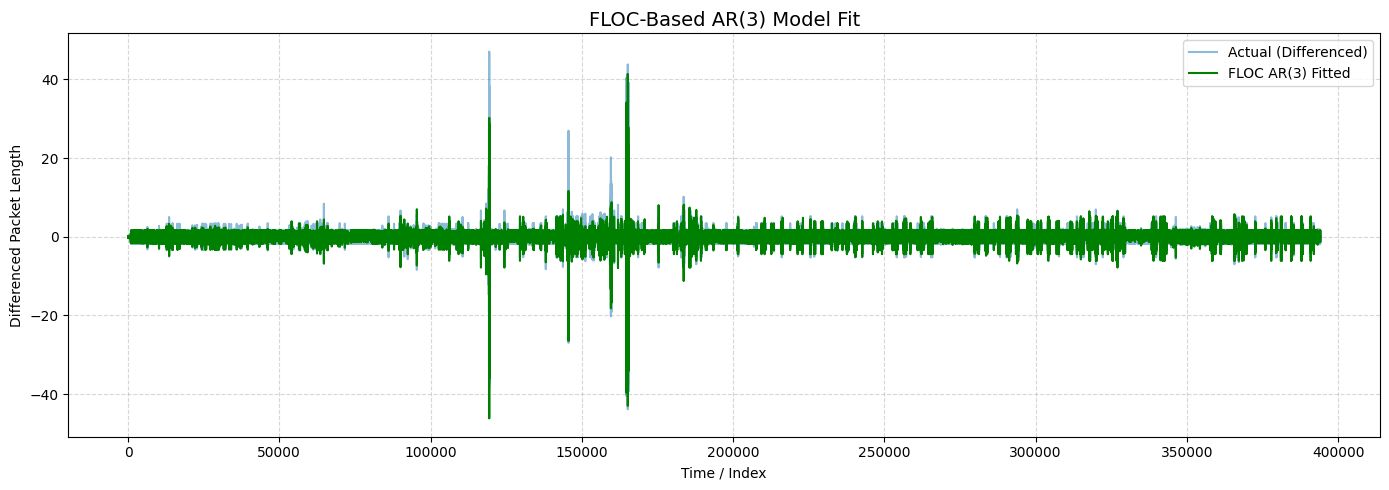


🔷 Fitting FLOC AR(5) model
Estimated coefficients: [-0.89354209 -0.57330519 -0.26382784 -0.18937414 -0.35963581]


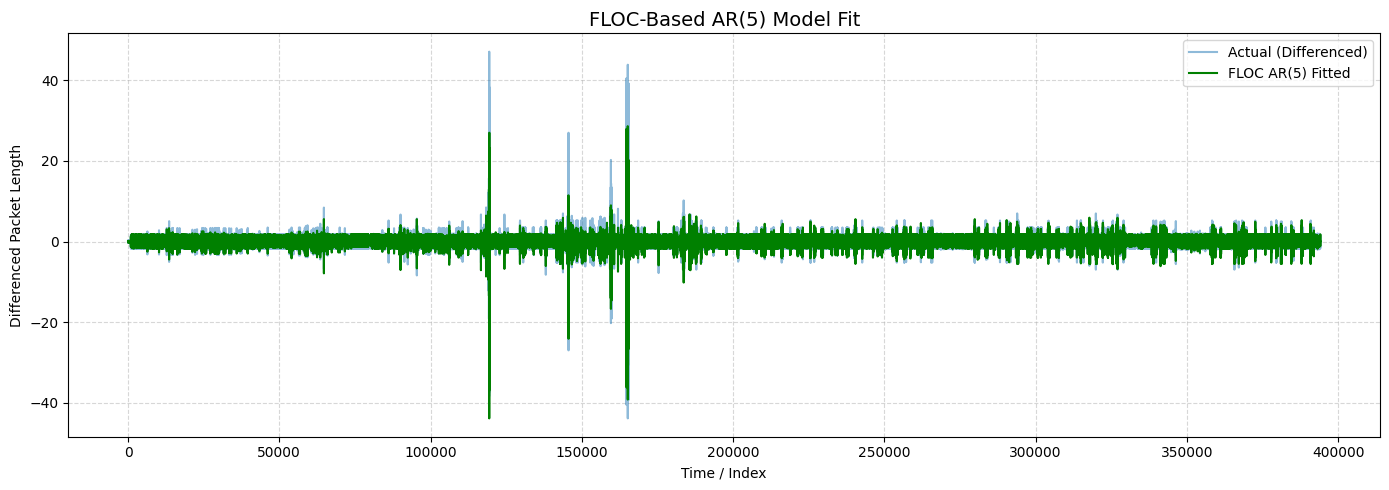


🔷 Fitting FLOC AR(10) model
Estimated coefficients: [-0.87989754 -0.59606778 -0.29251981 -0.21422102 -0.38029247 -0.08254014
 -0.18779662 -0.11960779 -0.0275319   0.03388969]


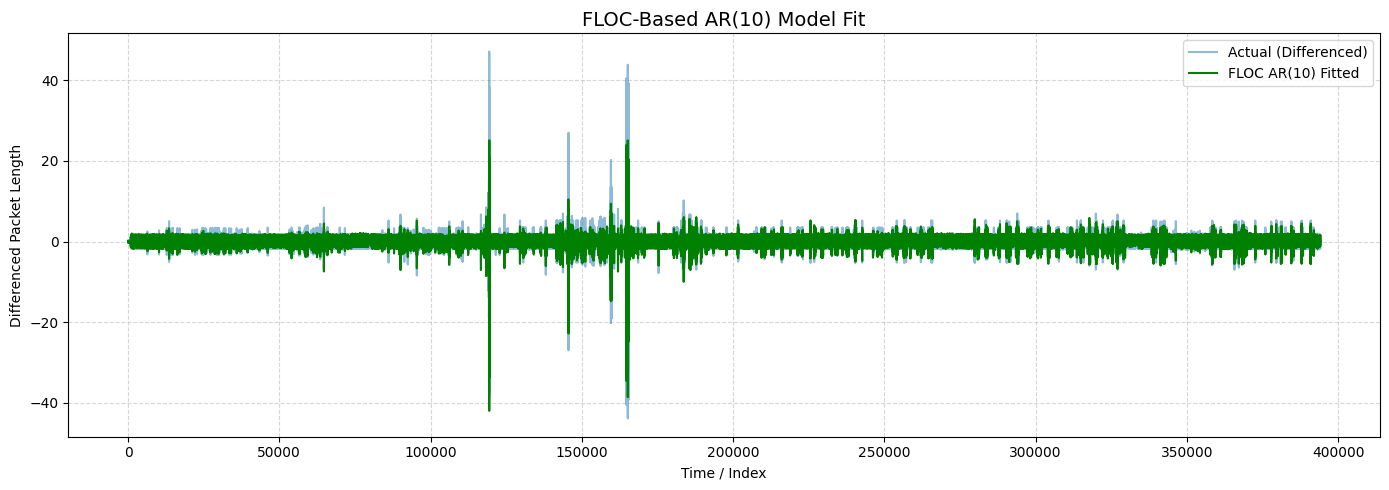

In [34]:
# --- Define alpha from regression and choose A, B ---
alpha = 0.889
A = (alpha - 0.1) / 2 + 0.1
B = (alpha - 0.1) / 2 - 0.1

# --- Ensure ts_stationary is a pandas Series ---
# Example if y_diff is already your differenced NumPy array:
ts_stationary = pd.Series(y_diff)

# --- Loop through multiple AR orders ---
for p in [2, 3, 5, 10]:
    print(f"\n🔷 Fitting FLOC AR({p}) model")
    phi = estimate_ar_floc(ts_stationary, p, A, B)
    print("Estimated coefficients:", phi)

    fitted_series = forecast_ar_floc_aligned(ts_stationary, phi)
    plot_floc_fit(ts_stationary, fitted_series, p)


# MAE (Mean Absolute Error) check

In [40]:
from sklearn.metrics import mean_absolute_error

def compute_mae(actual_series, fitted_series):
    # Align and drop NaN values
    df = pd.DataFrame({'Actual': actual_series, 'Fitted': fitted_series}).dropna()
    return mean_absolute_error(df['Actual'], df['Fitted'])


In [41]:
print("\n📊 Mean Absolute Error (MAE) Summary:")
for p, mae in mae_results.items():
    print(f"AR({p}): MAE = {round(mae, 4)}")



📊 Mean Absolute Error (MAE) Summary:
AR(2): MAE = 0.5981
AR(3): MAE = 0.5873
AR(5): MAE = 0.5215
AR(10): MAE = 0.5162


# Comparison with other models

In [36]:
from statsmodels.tsa.ar_model import AutoReg

def classical_yw_ar(ts_series, p):
    model = AutoReg(ts_series, lags=p, old_names=False)
    model_fit = model.fit()
    fitted_values = model_fit.fittedvalues
    # Pad beginning with NaNs to align with full series
    fitted_values = pd.Series(fitted_values, index=ts_series.index[p:])
    fitted_values = pd.concat([pd.Series([np.nan]*p, index=ts_series.index[:p]), fitted_values])
    return fitted_values


In [37]:
from scipy.linalg import toeplitz

def autocodifference(x, lag):
    n = len(x)
    codiff = []
    for h in range(lag + 1):
        diff = x[h:] - x[:n - h]
        codiff.append(np.mean(np.abs(diff - np.mean(diff))))
    return np.array(codiff)

def modified_yw_ar(ts_series, p):
    x = ts_series.values
    codiff_vals = autocodifference(x, lag=p)
    R = toeplitz(codiff_vals[:-1])
    r = codiff_vals[1:]
    phi = np.linalg.solve(R, r)

    # Forecast with padding
    fitted = [np.nan] * p
    for t in range(p, len(x)):
        pred = sum(phi[i] * x[t - i - 1] for i in range(p))
        fitted.append(pred)

    return pd.Series(fitted, index=ts_series.index)


In [38]:
mae_comparison = {'FLOC': {}, 'Classical_YW': {}, 'Modified_YW': {}}

for p in [2, 3, 5, 10]:
    print(f"\n🔁 Comparing Models for AR({p})")

    # FLOC
    phi_floc = estimate_ar_floc(ts_stationary, p, A, B)
    fitted_floc = forecast_ar_floc_aligned(ts_stationary, phi_floc)
    mae_floc = compute_mae(ts_stationary, fitted_floc)
    mae_comparison['FLOC'][p] = mae_floc
    print(f"FLOC MAE: {round(mae_floc, 4)}")

    # Classical Yule-Walker
    fitted_classical = classical_yw_ar(ts_stationary, p)
    mae_classical = compute_mae(ts_stationary, fitted_classical)
    mae_comparison['Classical_YW'][p] = mae_classical
    print(f"Classical YW MAE: {round(mae_classical, 4)}")

    # Modified Yule-Walker
    fitted_mod_yw = modified_yw_ar(ts_stationary, p)
    mae_mod_yw = compute_mae(ts_stationary, fitted_mod_yw)
    mae_comparison['Modified_YW'][p] = mae_mod_yw
    print(f"Modified YW MAE: {round(mae_mod_yw, 4)}")



🔁 Comparing Models for AR(2)
FLOC MAE: 0.5981
Classical YW MAE: 0.6087
Modified YW MAE: 1.2942

🔁 Comparing Models for AR(3)
FLOC MAE: 0.5873
Classical YW MAE: 0.5991
Modified YW MAE: 0.9333

🔁 Comparing Models for AR(5)
FLOC MAE: 0.5215
Classical YW MAE: 0.5399
Modified YW MAE: 0.7483

🔁 Comparing Models for AR(10)
FLOC MAE: 0.5162
Classical YW MAE: 0.5346
Modified YW MAE: 0.6597


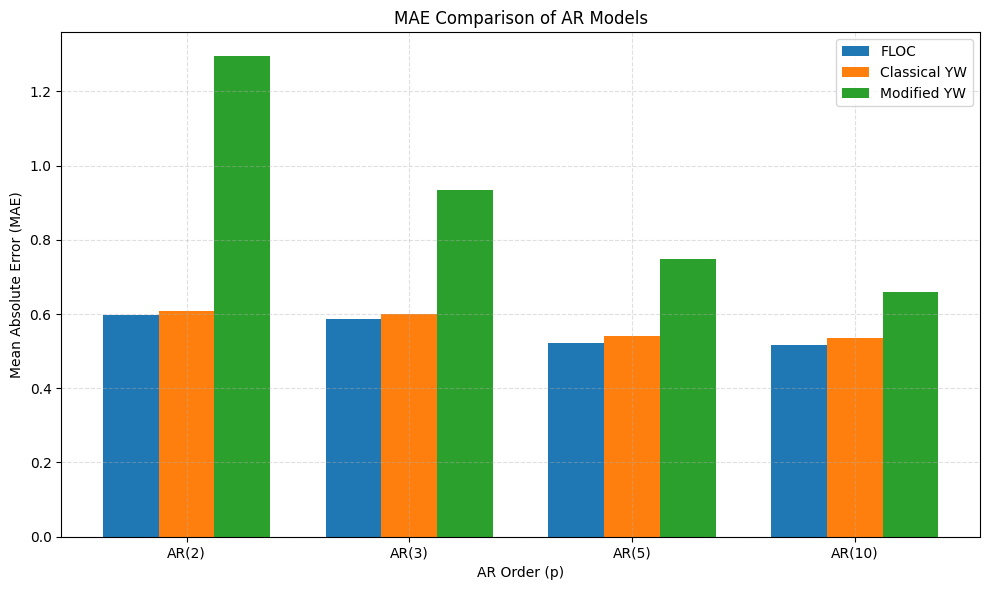

In [39]:
import matplotlib.pyplot as plt

labels = [2, 3, 5, 10]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, [mae_comparison['FLOC'][p] for p in labels], width, label='FLOC')
bar2 = ax.bar(x, [mae_comparison['Classical_YW'][p] for p in labels], width, label='Classical YW')
bar3 = ax.bar(x + width, [mae_comparison['Modified_YW'][p] for p in labels], width, label='Modified YW')

ax.set_xlabel("AR Order (p)")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("MAE Comparison of AR Models")
ax.set_xticks(x)
ax.set_xticklabels([f'AR({p})' for p in labels])
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()
